In [1]:
import os 
import warnings
import pickle

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

if not os.path.exists("figures"):
    os.mkdir("figures")

In [2]:
def get_results_table(use_test, preprocess_type, hpo, metric, model_names, eval_type="performance"):

    mean_val_perf = {}
    for dataset_name in dataset_names:
        mean_val_perf[dataset_name] = {}
        if dataset_name=="ieee-fraud-detection":
            n_folds = 6
        else:
            n_folds = 10
            
        for model_name in model_names:
            # print(dataset_name,model_name)
            try:
                if metric == "val":
                    perf = np.mean([results[dataset_name][preprocess_type][f"use_test_{use_test}"][model_name][hpo]["performance"]["Val"][f"fold_{i}"] for i in range(n_folds)])
                
                else:
                    perf = results[dataset_name][preprocess_type][f"use_test_{use_test}"][model_name][hpo][eval_type]["Test"][metric]
                # else:
                #     perf = np.nan
                # if dataset_name=="santander-value-prediction-challenge":
                    # perf *=-1
                    # perf /=10
            except:
                perf = np.nan
            if dataset_name in ["santander-value-prediction-challenge", "otto-group-product-classification-challenge", "bnp-paribas-cardif-claims-management"] and metric in ["private_score","public_score"]:
                mean_val_perf[dataset_name][model_name] = 1-perf
            else:
                mean_val_perf[dataset_name][model_name] = perf
    df = pd.DataFrame(mean_val_perf).transpose()
    return df    


In [3]:
exp_name="neurips24"
seed = 42

dataset_names = ['mercedes-benz-greener-manufacturing',
       'santander-value-prediction-challenge',
       'amazon-employee-access-challenge',
       'otto-group-product-classification-challenge',
       'santander-customer-satisfaction',
       'bnp-paribas-cardif-claims-management',
       'santander-customer-transaction-prediction', 
       "homesite-quote-conversion",
       'ieee-fraud-detection',
       'porto-seguro-safe-driver-prediction',
                ] 
model_names = ["XGBoost", "LightGBM", "CatBoost", "ResNet", "FTTransformer", "MLP-PLR", "GRANDE"]
preprocess_types = ["expert", 'minimalistic']
seed = 42

warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore")

results = {}

for dataset_name in dataset_names:
    results[dataset_name] = {}
    for preprocess_type in preprocess_types:
        results[dataset_name][preprocess_type] = {}
        for use_test in [False, True]:
            results[dataset_name][preprocess_type][f"use_test_{use_test}"] = {}
            for model_name in model_names:
                results[dataset_name][preprocess_type][f"use_test_{use_test}"][model_name] = {}
                for tune in [False, True]:
                    if use_test:
                        exp_name_use = exp_name+"_test"
                    else:
                        exp_name_use = exp_name+"_notest"
                    if tune:
                        exp_name_use += "_tuned"


                    
                    ### Conditions
                    # Minimalistic preprocessing only has relevant distinction for use_test when numerical features are present - can skip it
                    if preprocess_type == "minimalistic" and use_test:
                        if not tune:
                            results[dataset_name][preprocess_type][f"use_test_{use_test}"][model_name]["default"] = {}
                        else:
                            results[dataset_name][preprocess_type][f"use_test_{use_test}"][model_name]["hpo"] = {}
                        continue
    
                    # First check on default whether there is a difference
                    # if use_test and tune:
                    #     continue
                    
                    try:
                        if not tune:
                           if use_test and dataset_name in ["mercedes-benz-greener-manufacturing", "santander-value-prediction-challenge", "bnp-paribas-cardif-claims-management", "homesite-quote-conversion"]:
                                exp_name_use = exp_name+"_notest"
                                with open(f'./results/{dataset_name}/{preprocess_type}/{model_name}/{exp_name_use}/{exp_name_use}_seed{seed}.pickle', 'rb') as handle:
                                    exp_results = pickle.load(handle)
                                results[dataset_name][preprocess_type][f"use_test_{use_test}"][model_name]["hpo"] = exp_results                    
                           else:
                               with open(f'./results/{dataset_name}/{preprocess_type}/{model_name}/{exp_name_use}/{exp_name_use}_seed{seed}.pickle', 'rb') as handle:
                                   exp_results = pickle.load(handle)
                               results[dataset_name][preprocess_type][f"use_test_{use_test}"][model_name]["default"] = exp_results
                        else:
                            # No operations that change how expert preprocessing is done betwen use_test True/False
                            if use_test and dataset_name in ["mercedes-benz-greener-manufacturing", "santander-value-prediction-challenge", "bnp-paribas-cardif-claims-management", "homesite-quote-conversion"]:
                                exp_name_use = exp_name+"_notest_tuned"
                                with open(f'./results/{dataset_name}/{preprocess_type}/{model_name}/{exp_name_use}/{exp_name_use}_seed{seed}.pickle', 'rb') as handle:
                                    exp_results = pickle.load(handle)
                                results[dataset_name][preprocess_type][f"use_test_{use_test}"][model_name]["hpo"] = exp_results                    

                            # Standard procedure
                            else:                            
                                with open(f'./results/{dataset_name}/{preprocess_type}/{model_name}/{exp_name_use}/{exp_name_use}_seed{seed}.pickle', 'rb') as handle:
                                    exp_results = pickle.load(handle)
                                results[dataset_name][preprocess_type][f"use_test_{use_test}"][model_name]["hpo"] = exp_results                    
                        print(f"Load {model_name} with tune={tune} on dataset {dataset_name} with {preprocess_type} preprocessing and use_test={use_test}")
                        # try:
                        #     if (n_trials is not None) and (model_name != "AutoGluon"):
                        #         exp_name_use = exp_name+"_tuned"
                        #     else:
                        #         exp_name_use = exp_name                            
                        #     sub = pd.read_csv(f"./results/{dataset_name}/submissions/{model_name}_{preprocess_type}_{exp_name_use}.csv")
                        # except:
                        #     print("No submission file found!")
                        
                    except:
                        print("----------------------------------------------")
                        print(f"Results not available for {model_name} with tune={tune} on dataset {dataset_name} with {preprocess_type} preprocessing and use_test={use_test}")
                        print("----------------------------------------------")
                        if not tune:
                            results[dataset_name][preprocess_type][f"use_test_{use_test}"][model_name]["default"] = {}
                        else:
                            results[dataset_name][preprocess_type][f"use_test_{use_test}"][model_name]["hpo"] = {}

Load XGBoost with tune=False on dataset mercedes-benz-greener-manufacturing with expert preprocessing and use_test=False
Load XGBoost with tune=True on dataset mercedes-benz-greener-manufacturing with expert preprocessing and use_test=False
Load LightGBM with tune=False on dataset mercedes-benz-greener-manufacturing with expert preprocessing and use_test=False
Load LightGBM with tune=True on dataset mercedes-benz-greener-manufacturing with expert preprocessing and use_test=False
Load CatBoost with tune=False on dataset mercedes-benz-greener-manufacturing with expert preprocessing and use_test=False
Load CatBoost with tune=True on dataset mercedes-benz-greener-manufacturing with expert preprocessing and use_test=False
Load ResNet with tune=False on dataset mercedes-benz-greener-manufacturing with expert preprocessing and use_test=False
Load ResNet with tune=True on dataset mercedes-benz-greener-manufacturing with expert preprocessing and use_test=False
Load FTTransformer with tune=False

In [4]:
import joblib
from itertools import product
from datasets import get_dataset
for model_name in model_names:
    for data_config in product(dataset_names,preprocess_types,[False, True]): 
        dataset_name, preprocess_type, use_test = data_config
        dataset = get_dataset(dataset_name)
        if use_test:
            exp_name_use = exp_name+"_test"
            exp_name_use_study = exp_name+"_test"
        else:
            exp_name_use = exp_name+"_notest"
            exp_name_use_study = exp_name+"_notest"
        exp_name_use += "_tuned"

        if dataset.eval_metric_name in ["mse","rmse","rmsle","logloss","mlogloss","multilabel"]:
            direction = "minimize"
        else:
            direction = "maximize"

        
        if preprocess_type == "minimalistic" and use_test:
            results[dataset_name][preprocess_type][f"use_test_{use_test}"][model_name]["hpo"]["performance_oneconfig"] = {}
            public_score, private_score, public_rank, public_percentile, private_rank, private_percentile = [np.nan,np.nan,np.nan,np.nan,np.nan,np.nan]
        elif use_test and dataset_name in ["mercedes-benz-greener-manufacturing", "santander-value-prediction-challenge", "bnp-paribas-cardif-claims-management", "homesite-quote-conversion"]:
            # print("!!!")
            results[dataset_name][preprocess_type][f"use_test_{use_test}"][model_name]["hpo"]["performance_oneconfig"] = {}
            public_score, private_score, public_rank, public_percentile, private_rank, private_percentile = [np.nan,np.nan,np.nan,np.nan,np.nan,np.nan]
        else:
            results[dataset_name][preprocess_type][f"use_test_{use_test}"][model_name]["hpo"]["performance_oneconfig"] = {}        
                    
            use_test = str(use_test)
            if os.path.exists(f'results/{dataset_name}/{preprocess_type}/{model_name}/{exp_name_use}/{exp_name_use}_oneconfig.pickle'):
                print(f"Results already exist: {f'results/{dataset_name}/{preprocess_type}/{model_name}/{exp_name_use}/{exp_name_use}_oneconfig.pickle'}.")
                with open(f'results/{dataset_name}/{preprocess_type}/{model_name}/{exp_name_use}/{exp_name_use}_oneconfig.pickle', 'rb') as handle:
                    public_score, private_score, public_rank, public_percentile, private_rank, private_percentile = pickle.load(handle)
            else:    
                try:
                    # print(f"Get HPO results for {model_name} with tune={tune} on dataset {dataset_name} with {preprocess_type} preprocessing and use_test={use_test}")
                    if dataset_name in ["ieee-fraud-detection"]:
                        n_folds = 6
                    # elif dataset_name in ["porto-seguro-safe-driver-prediction"] and preprocess_type=="minimalistic":
                    #     n_folds = 5
                    else:
                        n_folds = 10
                    
                    save_path = f'results/{dataset_name}/{preprocess_type}/{model_name}'
                    values = []
                    predictions = []
                    for num_fold in range(n_folds):
                        fold_string = f"fold_{num_fold}"
                        study = joblib.load(f'{save_path}/{exp_name_use}/{fold_string}/{exp_name_use_study}_study.pkl')
                        trials = study.get_trials()
                        # print(study.best_trial.values,study.best_trial.params)
                        if direction =="maximize":
                            values.append([trials[i].values[0] if trials[i].values is not None else -np.inf for i in range(100)])
                        elif direction =="minimize":
                            values.append([trials[i].values[0] if trials[i].values is not None else np.inf for i in range(100)])
                        predictions.append([trials[i].user_attrs["predictions"] for i in range(100)])
                    values = np.array(values)
                    # print(f"{model_name} with tune={tune} on dataset {dataset_name} with {preprocess_type} preprocessing and use_test={use_test}:")
                    failed = np.logical_or(values==np.inf,values==-np.inf)
                    # print(f"{failed.sum()} trials failed, fold with highest no. of failures: {failed.sum(axis=1).max()}, config with highest no. of failures: {failed.sum(axis=0).max()}")
                    # print("----------------------------------------------")
                # Default
    
                    # print(f"Get one config results for {model_name} with tune={tune} on dataset {dataset_name} with {preprocess_type} preprocessing and use_test={use_test}")
                    n_folds = len(predictions)    
                    if direction=="maximize":
                        best_average_predictions = np.mean([predictions[num_fold][values.mean(axis=0).argmax()][2] for num_fold in range(n_folds)], axis=0)
                    else:
                        best_average_predictions = np.mean([predictions[num_fold][values.mean(axis=0).argmin()][2] for num_fold in range(n_folds)], axis=0)
                        
                    submission = dataset.pred_to_submission(best_average_predictions)
                        
                    save_name = f'results/{dataset_name}/{preprocess_type}/{model_name}/{exp_name_use}/{model_name}_{preprocess_type}_{exp_name_use}_oneconfig.csv'
                    submission.to_csv(save_name,index=False)        
                    oneconfig_res = dataset.submit_data(save_name)
                        
                    with open(f'results/{dataset_name}/{preprocess_type}/{model_name}/{exp_name_use}/{exp_name_use}_oneconfig.pickle', 'wb') as handle:
                        pickle.dump(oneconfig_res, handle, protocol=pickle.HIGHEST_PROTOCOL)
                    public_score, private_score, public_rank, public_percentile, private_rank, private_percentile = oneconfig_res
                    print(f"Successfull: {model_name} with tune={tune} on dataset {dataset_name} with {preprocess_type} preprocessing and use_test={use_test}")
                
                except:
                    print(f"Something gone wrong with {model_name}, {data_config} not available")
                    # print("----------------------------------------------")
                    public_score, private_score, public_rank, public_percentile, private_rank, private_percentile = [np.nan,np.nan,np.nan,np.nan,np.nan,np.nan]
            
        results[dataset_name][preprocess_type][f"use_test_{use_test}"][model_name]["hpo"]["performance_oneconfig"]["Test"] = {
                  "public_score": public_score, 
                  "private_score": private_score, 
                  "public_rank": public_rank, 
                  "public_percentile": public_percentile, 
                  "private_rank": private_rank, 
                  "private_percentile": private_percentile
                 }
        print(results[dataset_name][preprocess_type][f"use_test_{use_test}"][model_name]["hpo"]["performance_oneconfig"]["Test"])
        print("---------------------------------------------------")
        


2024-06-12 11:34:17.380842: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-12 11:34:18.872563: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Results already exist: results/mercedes-benz-greener-manufacturing/expert/XGBoost/neurips24_notest_tuned/neurips24_notest_tuned_oneconfig.pickle.
{'public_score': 0.55804, 'private_score': 0.55363, 'public_rank': 1729, 'public_percentile': 0.45214435146443516, 'private_rank': 25, 'private_percentile': 0.00653765690376569}
---------------------------------------------------
{'public_score': nan, 'private_score': nan, 'public_rank': nan, 'public_percentile': nan, 'private_rank': nan, 'private_percentile': nan}
---------------------------------------------------
Results already exist: results/mercedes-benz-greener-manufacturing/minimalistic/XGBoost/neurips24_notest_tuned/neurips24_notest_tuned_oneconfig.pickle.
{'public_score': 0.55078, 'private_score': 0.54784, 'public_rank': 2576, 'public_percentile': 0.6736401673640168, 'private_rank': 1603, 'private_percentile': 0.41919456066945604}
---------------------------------------------------
{'public_score': nan, 'private_score': nan, 'public

In [5]:
### Investigate Performance after random search
import joblib
from itertools import product
from datasets import get_dataset
for model_name in model_names:
    for data_config in product(dataset_names,preprocess_types,[False, True]): 
        dataset_name, preprocess_type, use_test = data_config
        dataset = get_dataset(dataset_name)
        if use_test:
            exp_name_use = exp_name+"_test"
            exp_name_use_study = exp_name+"_test"
        else:
            exp_name_use = exp_name+"_notest"
            exp_name_use_study = exp_name+"_notest"
        exp_name_use += "_tuned"

        if dataset.eval_metric_name in ["mse","rmse","rmsle","logloss","mlogloss","multilabel"]:
            direction = "minimize"
        else:
            direction = "maximize"

        
        if preprocess_type == "minimalistic" and use_test:
            results[dataset_name][preprocess_type][f"use_test_{use_test}"][model_name]["hpo"]["performance_20trials"] = {}
            public_score, private_score, public_rank, public_percentile, private_rank, private_percentile = [np.nan,np.nan,np.nan,np.nan,np.nan,np.nan]
        elif use_test and dataset_name in ["mercedes-benz-greener-manufacturing", "santander-value-prediction-challenge", "bnp-paribas-cardif-claims-management", "homesite-quote-conversion"]:
            # print("!!!")
            results[dataset_name][preprocess_type][f"use_test_{use_test}"][model_name]["hpo"]["performance_20trials"] = {}
            public_score, private_score, public_rank, public_percentile, private_rank, private_percentile = [np.nan,np.nan,np.nan,np.nan,np.nan,np.nan]
        else:
            results[dataset_name][preprocess_type][f"use_test_{use_test}"][model_name]["hpo"]["performance_20trials"] = {}        
                    
            use_test = str(use_test)
            if os.path.exists(f'results/{dataset_name}/{preprocess_type}/{model_name}/{exp_name_use}/{exp_name_use}_20trials.pickle'):
                print(f"Results already exist: {f'results/{dataset_name}/{preprocess_type}/{model_name}/{exp_name_use}/{exp_name_use}_oneconfig.pickle'}.")
                with open(f'results/{dataset_name}/{preprocess_type}/{model_name}/{exp_name_use}/{exp_name_use}_20trials.pickle', 'rb') as handle:
                    public_score, private_score, public_rank, public_percentile, private_rank, private_percentile = pickle.load(handle)
            else:    
                try:
                    # print(f"Get HPO results for {model_name} with tune={tune} on dataset {dataset_name} with {preprocess_type} preprocessing and use_test={use_test}")
                    if dataset_name in ["ieee-fraud-detection"]:
                        n_folds = 6
                    # elif dataset_name in ["porto-seguro-safe-driver-prediction"] and preprocess_type=="minimalistic":
                    #     n_folds = 5
                    else:
                        n_folds = 10
                    
                    save_path = f'results/{dataset_name}/{preprocess_type}/{model_name}'
                    values = []
                    predictions = []
                    for num_fold in range(n_folds):
                        fold_string = f"fold_{num_fold}"
                        study = joblib.load(f'{save_path}/{exp_name_use}/{fold_string}/{exp_name_use_study}_study.pkl')
                        trials = study.get_trials()
                        # print(study.best_trial.values,study.best_trial.params)
                        if direction =="maximize":
                            values.append([trials[i].values[0] if trials[i].values is not None else -np.inf for i in range(20)])
                        elif direction =="minimize":
                            values.append([trials[i].values[0] if trials[i].values is not None else np.inf for i in range(20)])
                        predictions.append([trials[i].user_attrs["predictions"] for i in range(20)])
                    values = np.array(values)
    
                    n_folds = len(predictions)
                    test_preds = np.array([[preds[2] for preds in predictions[num_fold][:20]] for num_fold in range(len(predictions))])
                    if direction=="maximize":
                        trial_20_preds = np.mean([test_preds[num_fold][values[num_fold,:20].argmax()] for num_fold in range(len(predictions))],axis=0)
                    else:
                        trial_20_preds = np.mean([test_preds[num_fold][values[num_fold,:20].argmin()] for num_fold in range(len(predictions))],axis=0)
                        
                    dataset = get_dataset(dataset_name)
                    submission = dataset.pred_to_submission(trial_20_preds)
                    
                    save_name = f'results/{dataset_name}/{preprocess_type}/{model_name}/{exp_name_use}/{model_name}_{preprocess_type}_{exp_name_use}_20trials.csv'
                    submission.to_csv(save_name,index=False)        
                    trials_20_res = dataset.submit_data(save_name)
                    
                    with open(f'results/{dataset_name}/{preprocess_type}/{model_name}/{exp_name_use}/{exp_name_use}_20trials.pickle', 'wb') as handle:
                        pickle.dump(trials_20_res, handle, protocol=pickle.HIGHEST_PROTOCOL)
                    
                    public_score, private_score, public_rank, public_percentile, private_rank, private_percentile = trials_20_res
    
                    print(f"Successfull: {model_name} with tune={tune} on dataset {dataset_name} with {preprocess_type} preprocessing and use_test={use_test}")
                
                except:
                    print(f"Something gone wrong with {model_name}, {data_config} not available")
                    # print("----------------------------------------------")
                    public_score, private_score, public_rank, public_percentile, private_rank, private_percentile = [np.nan,np.nan,np.nan,np.nan,np.nan,np.nan]
            
        results[dataset_name][preprocess_type][f"use_test_{use_test}"][model_name]["hpo"]["performance_20trials"]["Test"] = {
                  "public_score": public_score, 
                  "private_score": private_score, 
                  "public_rank": public_rank, 
                  "public_percentile": public_percentile, 
                  "private_rank": private_rank, 
                  "private_percentile": private_percentile
                 }
        print(results[dataset_name][preprocess_type][f"use_test_{use_test}"][model_name]["hpo"]["performance_20trials"]["Test"])
        print("---------------------------------------------------")
        


Results already exist: results/mercedes-benz-greener-manufacturing/expert/XGBoost/neurips24_notest_tuned/neurips24_notest_tuned_oneconfig.pickle.
{'public_score': 0.55987, 'private_score': 0.55341, 'public_rank': 1566, 'public_percentile': 0.40951882845188287, 'private_rank': 34, 'private_percentile': 0.00889121338912134}
---------------------------------------------------
{'public_score': nan, 'private_score': nan, 'public_rank': nan, 'public_percentile': nan, 'private_rank': nan, 'private_percentile': nan}
---------------------------------------------------
Results already exist: results/mercedes-benz-greener-manufacturing/minimalistic/XGBoost/neurips24_notest_tuned/neurips24_notest_tuned_oneconfig.pickle.
{'public_score': 0.55266, 'private_score': 0.54741, 'public_rank': 2374, 'public_percentile': 0.62081589958159, 'private_rank': 1713, 'private_percentile': 0.4479602510460251}
---------------------------------------------------
{'public_score': nan, 'private_score': nan, 'public_ra

In [6]:
metric = "private_score"
df_min_def = get_results_table(use_test=False, preprocess_type="minimalistic", hpo="default", metric=metric, model_names=model_names, eval_type="performance")
df_fe_def = get_results_table(use_test=False, preprocess_type="expert", hpo="default", metric=metric, model_names=model_names, eval_type="performance")
df_tta_def = get_results_table(use_test=True, preprocess_type="expert", hpo="default", metric=metric, model_names=model_names, eval_type="performance")

df_min_light = get_results_table(use_test=False, preprocess_type="minimalistic", hpo="hpo", metric=metric, model_names=model_names, eval_type="performance_20trials")
df_fe_light = get_results_table(use_test=False, preprocess_type="expert", hpo="hpo", metric=metric, model_names=model_names, eval_type="performance_20trials")
df_tta_light = get_results_table(use_test=True, preprocess_type="expert", hpo="hpo", metric=metric, model_names=model_names, eval_type="performance_20trials")

df_min_extensive = get_results_table(use_test=False, preprocess_type="minimalistic", hpo="hpo", metric=metric, model_names=model_names, eval_type="performance")
df_fe_extensive = get_results_table(use_test=False, preprocess_type="expert", hpo="hpo", metric=metric, model_names=model_names, eval_type="performance")
df_tta_extensive = get_results_table(use_test=True, preprocess_type="expert", hpo="hpo", metric=metric, model_names=model_names, eval_type="performance")

df_min_extensive_ens = get_results_table(use_test=False, preprocess_type="minimalistic", hpo="hpo", metric=metric, model_names=model_names, eval_type="performance_ens")
df_fe_extensive_ens = get_results_table(use_test=False, preprocess_type="expert", hpo="hpo", metric=metric, model_names=model_names, eval_type="performance_ens")
df_tta_extensive_ens = get_results_table(use_test=True, preprocess_type="expert", hpo="hpo", metric=metric, model_names=model_names, eval_type="performance_ens")

df_min_extensive_oneconfig = get_results_table(use_test=False, preprocess_type="minimalistic", hpo="hpo", metric=metric, model_names=model_names, eval_type="performance_oneconfig")
df_fe_extensive_oneconfig = get_results_table(use_test=False, preprocess_type="expert", hpo="hpo", metric=metric, model_names=model_names, eval_type="performance_oneconfig")
df_tta_extensive_oneconfig = get_results_table(use_test=True, preprocess_type="expert", hpo="hpo", metric=metric, model_names=model_names, eval_type="performance_oneconfig")

df_tta_def.loc[["mercedes-benz-greener-manufacturing", "santander-value-prediction-challenge", "bnp-paribas-cardif-claims-management", "homesite-quote-conversion"]] = df_fe_def.loc[["mercedes-benz-greener-manufacturing", "santander-value-prediction-challenge", "bnp-paribas-cardif-claims-management", "homesite-quote-conversion"]]
df_tta_light.loc[["mercedes-benz-greener-manufacturing", "santander-value-prediction-challenge", "bnp-paribas-cardif-claims-management", "homesite-quote-conversion"]] = df_fe_light.loc[["mercedes-benz-greener-manufacturing", "santander-value-prediction-challenge", "bnp-paribas-cardif-claims-management", "homesite-quote-conversion"]]

### Get AutoML results

In [7]:
exp_name="neurips24"
seed = 42

model_names_auto = ["AutoGluon"]
preprocess_types = [None]
seed = 42

warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore")

for dataset_name in dataset_names:
    for preprocess_type in preprocess_types:
        if preprocess_type==None:
            preprocess_type = "None"
            results[dataset_name][preprocess_type] = {}
        for use_test in [False]:
            if preprocess_type=="None":
                results[dataset_name][preprocess_type][f"use_test_{use_test}"] = {}
            for model_name in model_names_auto:
                results[dataset_name][preprocess_type][f"use_test_{use_test}"][model_name] = {}
                exp_name_use = exp_name

                
                ### Conditions
                # Minimalistic preprocessing only has relevant distinction for use_test when numerical features are present - can skip it
                if preprocess_type == "minimalistic" and use_test:
                    continue
                
                try:
                    with open(f'./results/{dataset_name}/{preprocess_type}/{model_name}/{exp_name}/{exp_name}_seed{seed}.pickle', 'rb') as handle:
                        exp_results = pickle.load(handle)
                    results[dataset_name][preprocess_type][f"use_test_{use_test}"][model_name]["default"] = exp_results
                    print(f"Load {model_name} on dataset {dataset_name} with {preprocess_type} preprocessing")
                    
                except:
                    print("----------------------------------------------")
                    print(f"Results not available for {model_name} on dataset {dataset_name} with {preprocess_type} preprocessing")
                    print("----------------------------------------------")
                    results[dataset_name][preprocess_type][f"use_test_{use_test}"][model_name]["default"] = None


Load AutoGluon on dataset mercedes-benz-greener-manufacturing with None preprocessing
Load AutoGluon on dataset santander-value-prediction-challenge with None preprocessing
Load AutoGluon on dataset amazon-employee-access-challenge with None preprocessing
Load AutoGluon on dataset otto-group-product-classification-challenge with None preprocessing
Load AutoGluon on dataset santander-customer-satisfaction with None preprocessing
Load AutoGluon on dataset bnp-paribas-cardif-claims-management with None preprocessing
Load AutoGluon on dataset santander-customer-transaction-prediction with None preprocessing
Load AutoGluon on dataset homesite-quote-conversion with None preprocessing
Load AutoGluon on dataset ieee-fraud-detection with None preprocessing
Load AutoGluon on dataset porto-seguro-safe-driver-prediction with None preprocessing


In [8]:
exp_name="neurips24"
seed = 42

model_names_auto = ["AutoGluon"]
preprocess_types = ["expert"]
seed = 42

warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore")

for dataset_name in dataset_names:
    for preprocess_type in preprocess_types:
        for use_test in [False, True]:
            for model_name in model_names_auto:
                results[dataset_name][preprocess_type][f"use_test_{use_test}"][model_name] = {}
                if use_test:
                    exp_name_use = exp_name+"_test"
                else:
                    exp_name_use = exp_name+"_notest"
                
                ### Conditions
                # Minimalistic preprocessing only has relevant distinction for use_test when numerical features are present - can skip it
                if preprocess_type == "minimalistic" and use_test:
                    continue
                
                try:
                    if use_test and dataset_name in ["mercedes-benz-greener-manufacturing", "santander-value-prediction-challenge", "bnp-paribas-cardif-claims-management", "homesite-quote-conversion"]:
                        results[dataset_name][preprocess_type][f"use_test_{use_test}"][model_name]["default"] = results[dataset_name][preprocess_type][f"use_test_False"][model_name]["default"]
                    else:
                        with open(f'./results/{dataset_name}/{preprocess_type}/{model_name}/{exp_name_use}/{exp_name}_seed{seed}.pickle', 'rb') as handle:
                            exp_results = pickle.load(handle)
                        results[dataset_name][preprocess_type][f"use_test_{use_test}"][model_name]["default"] = exp_results
                        print(f"Load {model_name} on dataset {dataset_name} with {preprocess_type} preprocessing")
                    
                except:
                    try:
                        with open(f'./results/{dataset_name}/{preprocess_type}/{model_name}/{exp_name_use}/{exp_name_use}_seed{seed}.pickle', 'rb') as handle:
                            exp_results = pickle.load(handle)
                        results[dataset_name][preprocess_type][f"use_test_{use_test}"][model_name]["default"] = exp_results
                        print(f"Load {model_name} on dataset {dataset_name} with {preprocess_type} preprocessing")
                    except:
                        print("----------------------------------------------")
                        print(f"Results not available for {model_name} on dataset {dataset_name} with {preprocess_type} preprocessing")
                        print("----------------------------------------------")
                        results[dataset_name][preprocess_type][f"use_test_{use_test}"][model_name]["default"] = None


Load AutoGluon on dataset mercedes-benz-greener-manufacturing with expert preprocessing
Load AutoGluon on dataset santander-value-prediction-challenge with expert preprocessing
Load AutoGluon on dataset amazon-employee-access-challenge with expert preprocessing
Load AutoGluon on dataset amazon-employee-access-challenge with expert preprocessing
Load AutoGluon on dataset otto-group-product-classification-challenge with expert preprocessing
Load AutoGluon on dataset otto-group-product-classification-challenge with expert preprocessing
Load AutoGluon on dataset santander-customer-satisfaction with expert preprocessing
Load AutoGluon on dataset santander-customer-satisfaction with expert preprocessing
Load AutoGluon on dataset bnp-paribas-cardif-claims-management with expert preprocessing
Load AutoGluon on dataset santander-customer-transaction-prediction with expert preprocessing
Load AutoGluon on dataset santander-customer-transaction-prediction with expert preprocessing
Load AutoGluon o

In [9]:
df_min_auto = get_results_table(use_test=False, preprocess_type="None", hpo="default", metric="private_score", model_names=model_names_auto, eval_type="performance")
df_fe_auto = get_results_table(use_test=False, preprocess_type="expert", hpo="default", metric="private_score", model_names=model_names_auto, eval_type="performance")
df_tta_auto = get_results_table(use_test=True, preprocess_type="expert", hpo="default", metric="private_score", model_names=model_names_auto, eval_type="performance")


## Section 4, Figure 3: Overview of all results

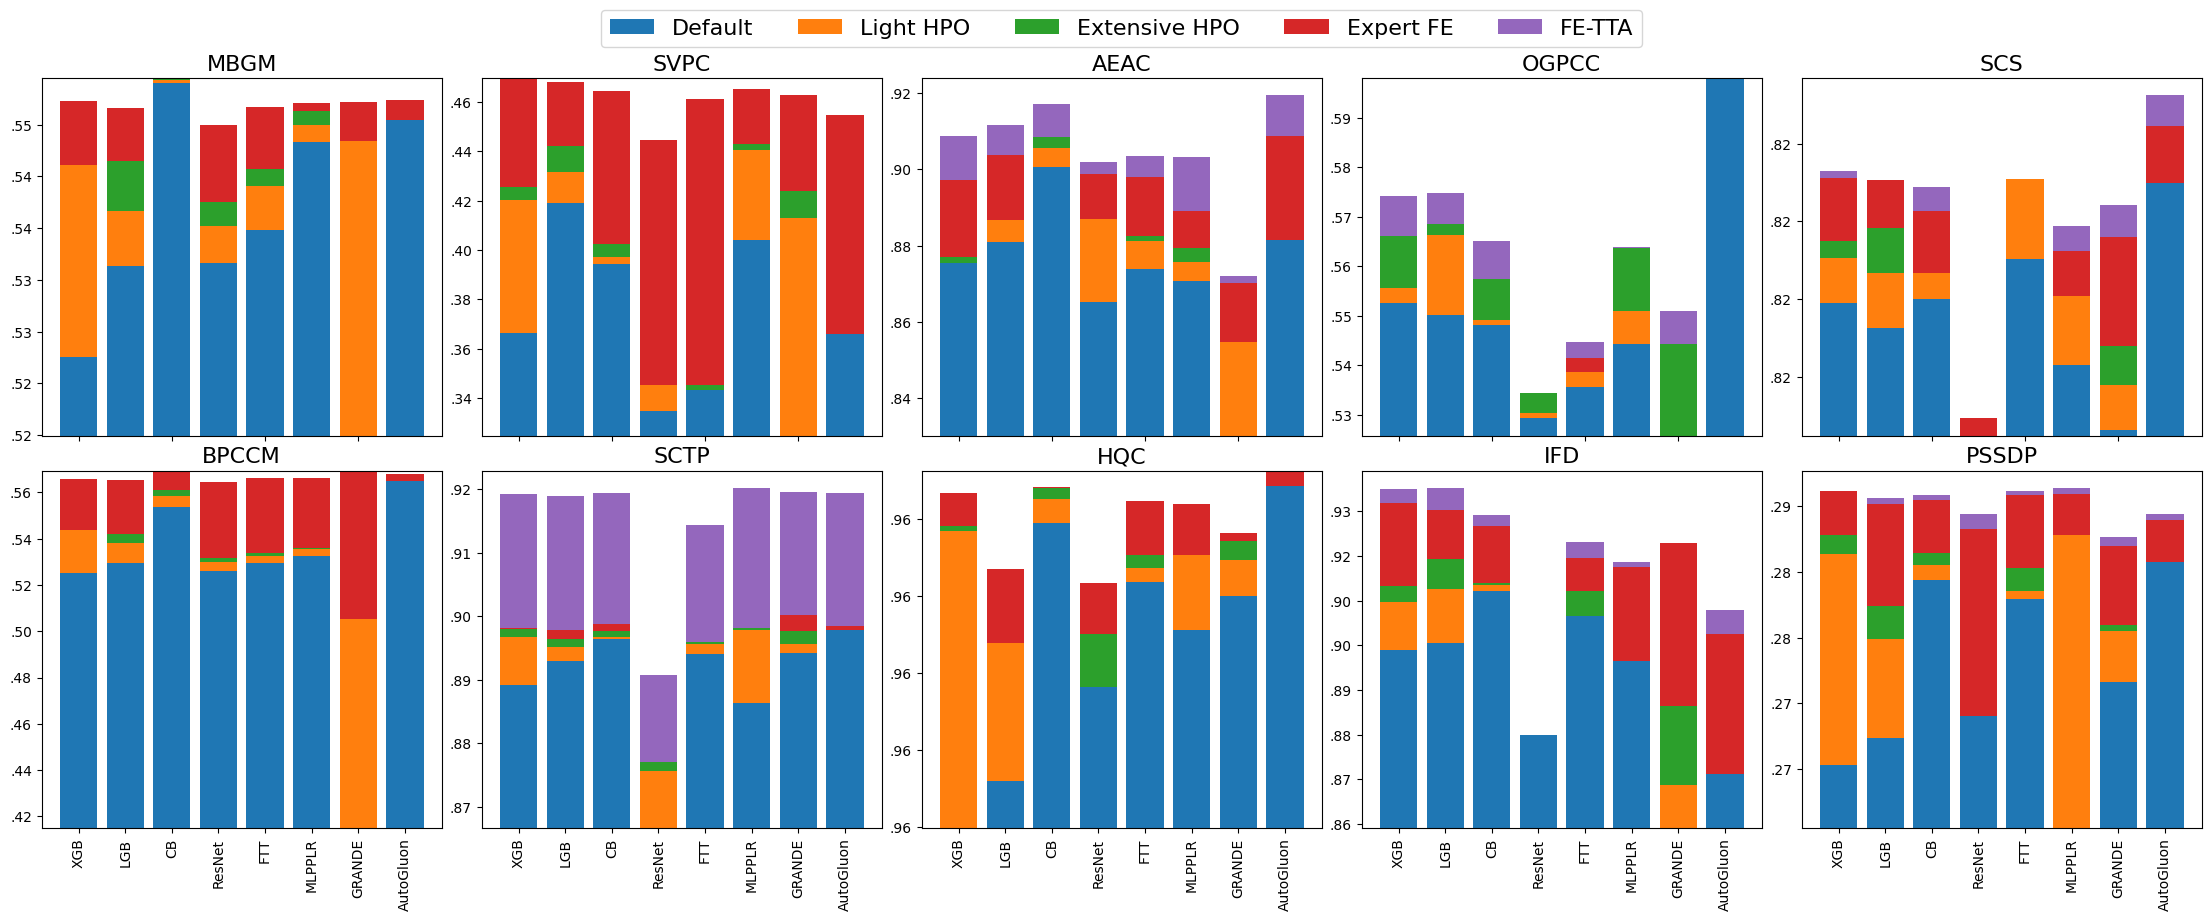

In [10]:
import matplotlib.pyplot as plt

model_map = {'XGBoost': "XGB", 'CatBoost': "CB", 'ResNet': 'ResNet', 'MLP-PLR': "MLPPLR", 'GRANDE': 'GRANDE', 'LightGBM': "LGB", "FTTransformer": "FTT", "AutoGluon": "AutoGluon"}
dataset_map = {'mercedes-benz-greener-manufacturing': "MBGM",
       'santander-value-prediction-challenge': "SVPC",
       'amazon-employee-access-challenge': "AEAC",
       'otto-group-product-classification-challenge': "OGPCC",
       'santander-customer-satisfaction': "SCS",
       'bnp-paribas-cardif-claims-management': "BPCCM",
       'santander-customer-transaction-prediction': "SCTP", 
       'homesite-quote-conversion': "HQC",
        'ieee-fraud-detection': "IFD",
       'porto-seguro-safe-driver-prediction': "PSSDP",
              }

# Set up the figure and axes
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(24, 10))

# Flatten the axes array for easy iteration
axes = axes.flatten()

light_hpo = df_min_def - df_min_light
extensive_hpo = df_min_light - df_min_extensive
# cash = df_min_extensive - df_min_extensive["CatBoost"]
expert_fe = df_min_extensive - df_fe_extensive
fe_tta = df_fe_extensive - df_tta_extensive

df_min_light_extoverfitadjusted = df_min_light.copy()
df_min_light_extoverfitadjusted[(df_min_extensive-df_min_light)<0] = df_min_extensive[(df_min_extensive-df_min_light)<0]
df_min_light_extoverfitadjusted

# Set font sizes for LaTeX readability
# plt.rc('text', usetex=True)
# plt.rc('font', family='serif')
# plt.rc('font', serif='Times New Roman')
plt.rc('font', size=14)
plt.rc('axes', titlesize=16)
plt.rc('axes', labelsize=14)
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)
plt.rc('legend', fontsize=14)

# Create the bar plots
for i in range(10):  # datasets
    bottom = [df_min_def.iloc[i].min()]*8 #np.zeros(8)
    axes[i].bar(np.arange(8), np.maximum(0, pd.concat([df_min_def,df_min_auto],axis=1).iloc[i] - bottom), bottom=bottom, label='Default')
    bottom += np.maximum(0, pd.concat([df_min_def,df_min_auto],axis=1).iloc[i] - bottom)
    axes[i].bar(np.arange(8), np.maximum(0, pd.concat([df_min_light_extoverfitadjusted,df_min_auto],axis=1).iloc[i] - bottom), bottom=bottom, label='Light HPO')
    bottom += np.maximum(0, pd.concat([df_min_light_extoverfitadjusted,df_min_auto],axis=1).iloc[i] - bottom)
    axes[i].bar(np.arange(8), np.maximum(0, pd.concat([df_min_extensive,df_min_auto],axis=1).iloc[i] - bottom), bottom=bottom, label='Extensive HPO')
    bottom += np.maximum(0, pd.concat([df_min_extensive,df_min_auto],axis=1).iloc[i] - bottom)
    axes[i].bar(np.arange(8), np.maximum(0, pd.concat([df_fe_extensive,df_fe_auto],axis=1).iloc[i] - bottom), bottom=bottom, label='Expert FE')
    bottom += np.maximum(0, pd.concat([df_fe_extensive,df_fe_auto],axis=1).iloc[i] - bottom)
    axes[i].bar(np.arange(8), np.maximum(0, pd.concat([df_tta_extensive,df_tta_auto],axis=1).iloc[i] - bottom), bottom=bottom, label='FE-TTA')
    # bottom += np.maximum(0, df_tta_extensive.iloc[i] - bottom)
    # axes[i].bar(np.arange(6), np.maximum(0, df_tta_extensive_ens.iloc[i] - bottom), bottom=bottom, label='Ensemble')
    
    axes[i].set_title(dataset_map[light_hpo.index[i]])
    
    # if i % 5 == 0:  # Leftmost column
    # axes[i].set_ylabel('Leaderboard Position')
        # axes[i].set_yticklabels([0.2,None,0.4,None,0.6,None,0.8,None,1.0])
    # else:
        # axes[i].set_yticklabels([])

    yticks = axes[i].get_yticks()
    axes[i].set_yticklabels([f'.{int(tick*100)}' for tick in yticks])
    
    
    if i >= 5:  # Bottom row
        axes[i].set_xticks(np.arange(8))
        axes[i].set_xticklabels([model_map[mod] for mod in list(expert_fe.columns)+["AutoGluon"]], rotation=90)
    else:
        axes[i].set_xticklabels([])
    
    # axes[i].set_ylim(0.0, 1.0)  # Adjust the y-axis limit to fit the data


# Create a single legend at the top of the figure
handles, labels = axes[5].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=5, bbox_to_anchor=(0.5, 1.03), fontsize=16)

# Adjust layout manually to prevent overlapping
plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.2, wspace=0.1, hspace=0.1)

# Save the plot as a PDF file
plt.savefig('figures/all_results_score.pdf', format='pdf', bbox_inches='tight', pad_inches=0)

plt.show()

In [11]:
def remove_outliers_iqr(df, column):
    """
    Remove outliers from a dataframe based on the IQR method.
    
    Parameters:
    df (pd.DataFrame): The input dataframe.
    column (str): The name of the column from which to remove outliers.
    
    Returns:
    pd.DataFrame: The dataframe with outliers removed.
    """
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Identify outliers
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    num_outliers = outliers.shape[0]
    
    # Filtering the dataframe
    df_filtered = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    
    print(f"Number of outliers removed: {num_outliers}")
    
    return df_filtered


Number of outliers removed: 554


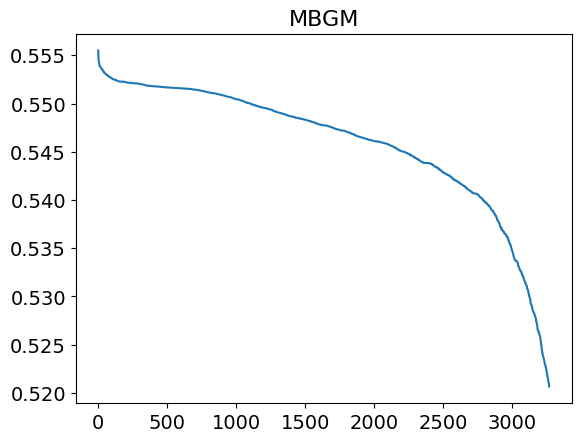

Number of outliers removed: 97


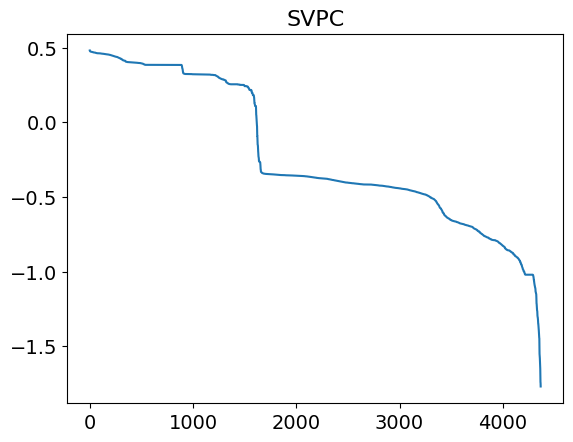

Number of outliers removed: 0


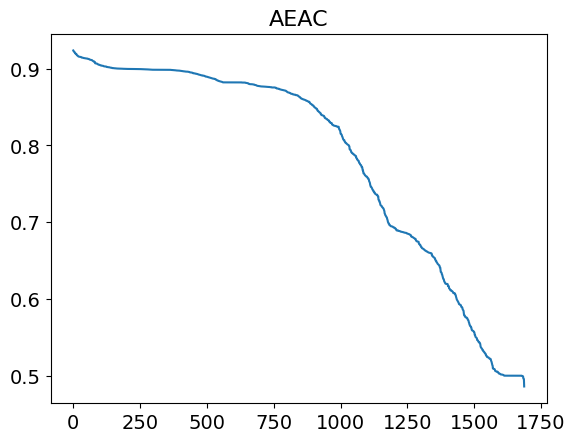

Number of outliers removed: 722


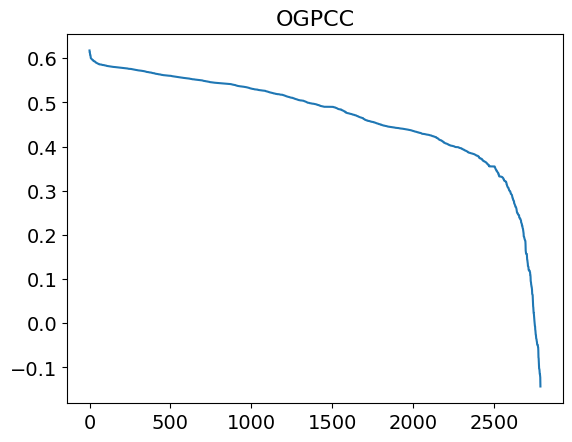

Number of outliers removed: 1037


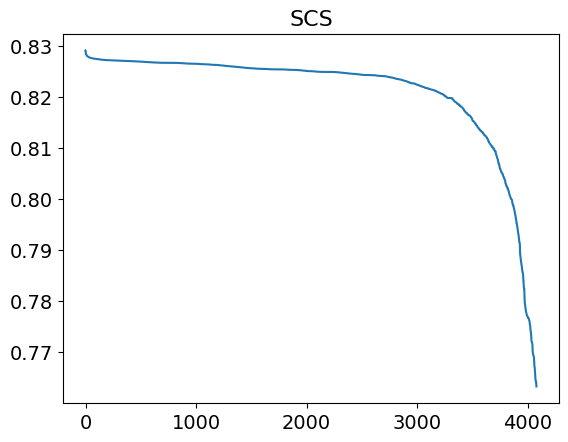

Number of outliers removed: 418


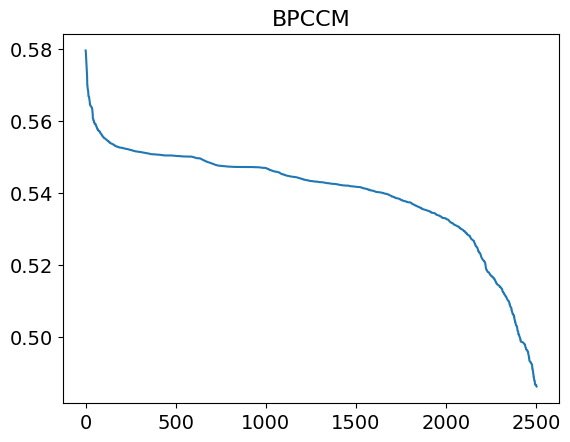

Number of outliers removed: 1740


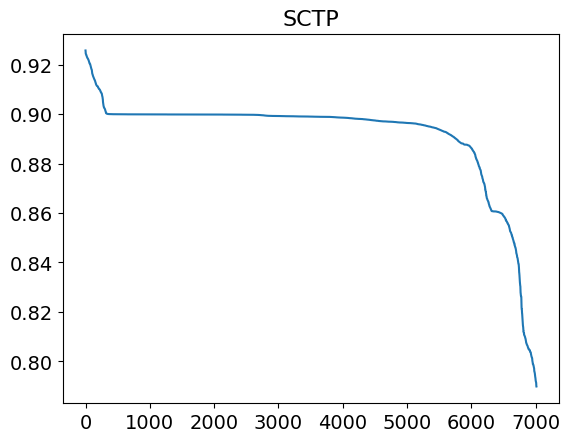

Number of outliers removed: 317


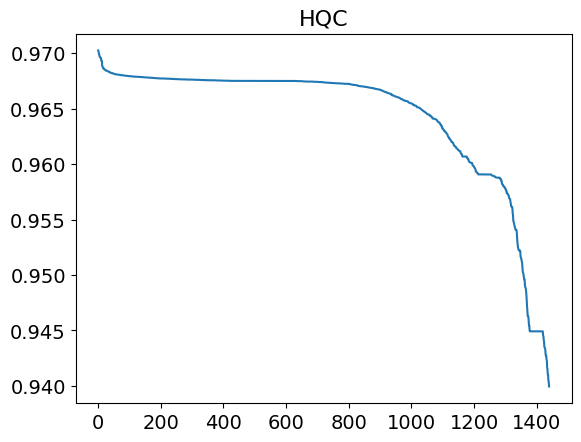

Number of outliers removed: 976


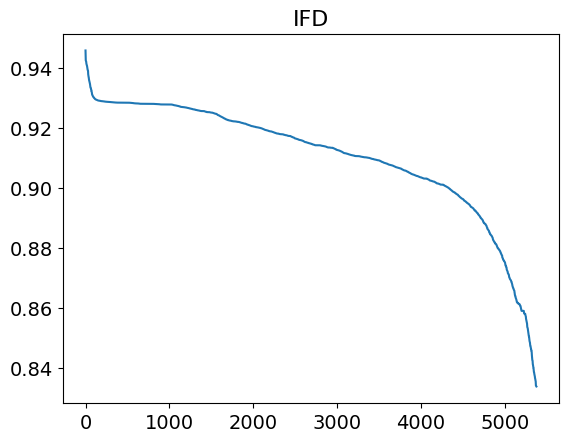

Number of outliers removed: 684


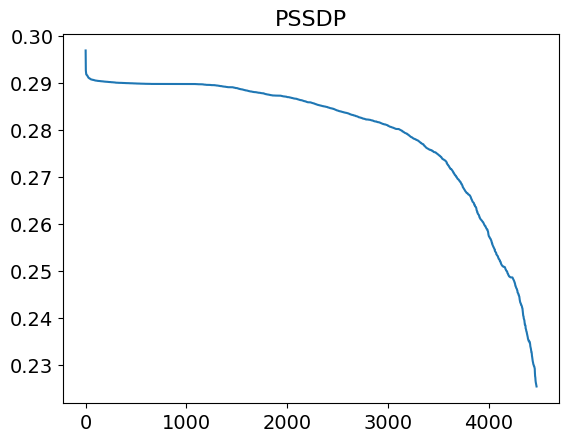

In [12]:
lb_dataset = {}
for dataset_name in dataset_names:
    lb_dataset[dataset_map[dataset_name]] = pd.read_csv(f"datasets/{dataset_name}/leaderboard.csv")
    
    lb_dataset[dataset_map[dataset_name]] = remove_outliers_iqr(lb_dataset[dataset_map[dataset_name]], "PrivateScore")
    if dataset_name in ["santander-value-prediction-challenge", "otto-group-product-classification-challenge", "bnp-paribas-cardif-claims-management"]:
        lb_dataset[dataset_map[dataset_name]] = 1-lb_dataset[dataset_map[dataset_name]]
    plt.plot(lb_dataset[dataset_map[dataset_name]]["PrivateScore"])
    plt.title(dataset_map[dataset_name])
    plt.show()

In [13]:
# ADTM metric
from sklearn.preprocessing import MinMaxScaler
adtm_scaler = MinMaxScaler()

def apply_adtm_data(perf_df):

    # min_ = lb_dataset[perf_df.name]["PrivateScore"].quantile(0.2)
    min_ = lb_dataset[perf_df.name]["PrivateScore"].min()
    max_ = lb_dataset[perf_df.name]["PrivateScore"].max()
    perf_df = (perf_df-min_) / (max_-min_) 

    
    # perf_df = pd.DataFrame(adtm_scaler.fit_transform((perf_df.transpose()*-1).copy()),
    #              index=perf_df.columns,
    #              columns=perf_df.index)
    return perf_df

### Subsection 4.1: How Model Comparisons Change

In [14]:
df_min_def.index = df_min_def.index.map(dataset_map)
df_fe_def.index = df_fe_def.index.map(dataset_map)
df_tta_def.index = df_tta_def.index.map(dataset_map)
df_min_light.index = df_min_light.index.map(dataset_map)
df_fe_light.index = df_fe_light.index.map(dataset_map)
df_tta_light.index = df_tta_light.index.map(dataset_map)
df_min_extensive.index = df_min_extensive.index.map(dataset_map)
df_fe_extensive.index = df_fe_extensive.index.map(dataset_map)
df_tta_extensive.index = df_tta_extensive.index.map(dataset_map)
df_min_auto.index = df_min_auto.index.map(dataset_map)
df_fe_auto.index = df_fe_auto.index.map(dataset_map)
df_tta_auto.index = df_tta_auto.index.map(dataset_map)

In [15]:
all_perf = pd.DataFrame([df_min_extensive.apply(apply_adtm_data,axis=1).values.ravel(),df_fe_extensive.apply(apply_adtm_data,axis=1).values.ravel(),df_tta_extensive.apply(apply_adtm_data,axis=1).values.ravel()],index=["Standardized", "Expert FE", "FE-TTA"]).transpose()
spearman_corr = all_perf.corr("spearman")
spearman_corr

,Standardized,Expert FE,FE-TTA
Standardized,1.000000,0.891076,0.828621
Expert FE,0.891076,1.000000,0.783910
FE-TTA,0.828621,0.783910,1.000000


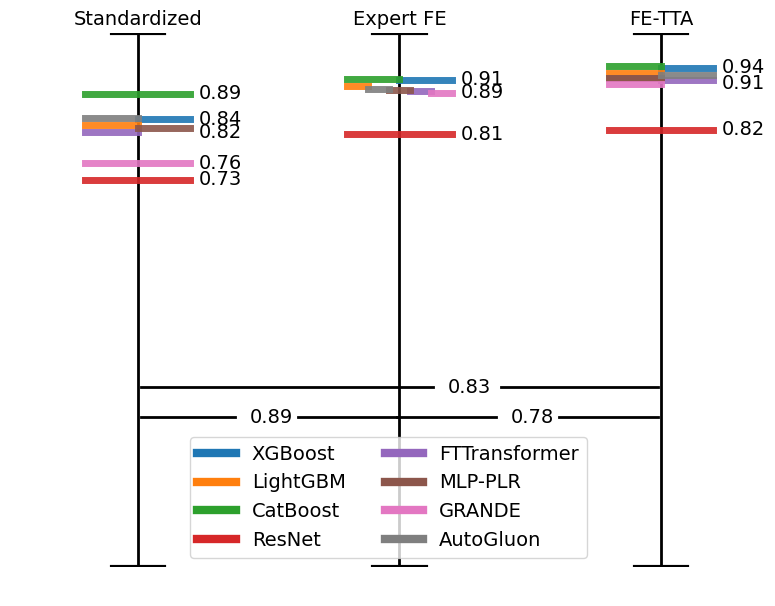

In [16]:
# Create a figure with one subplot per dataset
fig, axs = plt.subplots(1, 3, figsize=(9, 6))  # Adjust width as needed

y_labels = list(df_min_extensive.columns) + ["AutoGluon"]
colors = {i: j for i, j in zip(y_labels, ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f'])}

# Function to plot the data
def plot_data(ax, df,title):
    y_markers = list(np.mean(df,axis=0))
    # y_markers = list(np.median(df,axis=0))
    y_values = y_markers

    # Updated colors for publication
    ax.axvline(x=0, color='black', linestyle='-', linewidth=2)
    ax.axhline(y=0., color='black', linestyle='-', linewidth=3, xmin=0.35, xmax=0.65)
    ax.axhline(y=1., color='black', linestyle='-', linewidth=3, xmin=0.35, xmax=0.65)

    # Plot horizontal lines
    for y, label in zip(y_markers, y_labels):
        if title=="FE-TTA" and label=="CatBoost":
            ax.axhline(y=y, color=colors[label], linestyle='-', linewidth=5, xmin=0.2, xmax=0.5, alpha=0.9)  # Set alpha for transparency
        elif title=="FE-TTA" and label=="XGBoost":
            ax.axhline(y=y, color=colors[label], linestyle='-', linewidth=5, xmin=0.5, xmax=0.8, alpha=0.9)  # Set alpha for transparency
        elif title=="FE-TTA" and label=="LightGBM":
            ax.axhline(y=y, color=colors[label], linestyle='-', linewidth=5, xmin=0.2, xmax=0.5, alpha=0.9)  # Set alpha for transparency
        elif title=="FE-TTA" and label=="AutoGluon":
            ax.axhline(y=y, color=colors[label], linestyle='-', linewidth=5, xmin=0.5, xmax=0.8, alpha=0.9)  # Set alpha for transparency
        elif title=="FE-TTA" and label=="MLP-PLR":
            ax.axhline(y=y, color=colors[label], linestyle='-', linewidth=5, xmin=0.2, xmax=0.5, alpha=1.0)  # Set alpha for transparency
        elif title=="FE-TTA" and label=="FTTransformer":
            ax.axhline(y=y, color=colors[label], linestyle='-', linewidth=5, xmin=0.5, xmax=0.8, alpha=0.9)  # Set alpha for transparency
        elif title=="FE-TTA" and label=="GRANDE":
            ax.axhline(y=y, color=colors[label], linestyle='-', linewidth=5, xmin=0.2, xmax=0.5, alpha=0.9)  # Set alpha for transparency
        
        elif title=="Expert FE" and label=="CatBoost":
            ax.axhline(y=y, color=colors[label], linestyle='-', linewidth=5, xmin=0.2, xmax=0.5, alpha=0.9)  # Set alpha for transparency
        elif title=="Expert FE" and label=="XGBoost":
            ax.axhline(y=y, color=colors[label], linestyle='-', linewidth=5, xmin=0.5, xmax=0.8, alpha=0.9)  # Set alpha for transparency
        elif title=="Expert FE" and label=="LightGBM":
            ax.axhline(y=y, color=colors[label], linestyle='-', linewidth=5, xmin=0.2, xmax=0.32, alpha=0.9)  # Set alpha for transparency
        elif title=="Expert FE" and label=="AutoGluon":
            ax.axhline(y=y, color=colors[label], linestyle='-', linewidth=5, xmin=0.32, xmax=0.44, alpha=0.9)  # Set alpha for transparency
        elif title=="Expert FE" and label=="MLP-PLR":
            ax.axhline(y=y, color=colors[label], linestyle='-', linewidth=5, xmin=0.44, xmax=0.56, alpha=0.9)  # Set alpha for transparency
        elif title=="Expert FE" and label=="FTTransformer":
            ax.axhline(y=y, color=colors[label], linestyle='-', linewidth=5, xmin=0.56, xmax=0.68, alpha=0.9)  # Set alpha for transparency
        elif title=="Expert FE" and label=="GRANDE":
            ax.axhline(y=y, color=colors[label], linestyle='-', linewidth=5, xmin=0.68, xmax=0.8, alpha=0.9)  # Set alpha for transparency

        elif title=="Standardized" and label=="AutoGluon":
            ax.axhline(y=y, color=colors[label], linestyle='-', linewidth=5, xmin=0.2, xmax=0.5, alpha=0.9)  # Set alpha for transparency
        elif title=="Standardized" and label=="XGBoost":
            ax.axhline(y=y, color=colors[label], linestyle='-', linewidth=5, xmin=0.5, xmax=0.8, alpha=0.9)  # Set alpha for transparency
        elif title=="Standardized" and label=="LightGBM":
            ax.axhline(y=y, color=colors[label], linestyle='-', linewidth=5, xmin=0.2, xmax=0.5, alpha=0.9)  # Set alpha for transparency
        elif title=="Standardized" and label=="MLP-PLR":
            ax.axhline(y=y, color=colors[label], linestyle='-', linewidth=5, xmin=0.5, xmax=0.8, alpha=0.9)  # Set alpha for transparency
        elif title=="Standardized" and label=="FTTransformer":
            ax.axhline(y=y, color=colors[label], linestyle='-', linewidth=5, xmin=0.2, xmax=0.5, alpha=0.9)  # Set alpha for transparency
        else:
            ax.axhline(y=y, color=colors[label], linestyle='-', linewidth=5, xmin=0.2, xmax=0.8, alpha=0.9)  # Set alpha for transparency

    # Sort markers by their y-values
    sorted_markers = sorted(zip(y_markers, y_labels), key=lambda x: x[0])
    
    # Plot text for the highest value in case of overlap
    last_y = -float('inf')
    for y, label in sorted_markers:
        if y - last_y >= 0.02:  # Adjust threshold as needed to prevent overlap
            if label == "Best Expert Solution":
                ax.text(0.35, y, f'{y:.3f}', rotation=0, verticalalignment='center', horizontalalignment='left', fontsize=14, color='black')
            else:
                ax.text(0.35, y, f'{y:.2f}', rotation=0, verticalalignment='center', horizontalalignment='left', fontsize=14, color='black')
            last_y = y
    
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.set_xlim(-0.5, 0.5)
    ax.set_ylim(0, 1)
    ax.tick_params(axis='y', direction='out', length=10, width=2, colors='black', grid_color='black', grid_alpha=0.5)
    ax.set_title(title, fontsize=14)



min = pd.concat([df_min_extensive, df_min_auto], axis=1).apply(apply_adtm_data,axis=1)
fe = pd.concat([df_fe_extensive, df_fe_auto], axis=1).apply(apply_adtm_data,axis=1)
tta = pd.concat([df_tta_extensive, df_tta_auto], axis=1).apply(apply_adtm_data,axis=1)

# plot_data(axs[0], min, title="Standardized")
# plot_data(axs[1], np.max([min,fe],axis=0), title="Expert FE")
# plot_data(axs[2], np.max([min,fe,tta],axis=0), title="FE-TTA")

plot_data(axs[0], min, title="Standardized")
plot_data(axs[1], fe, title="Expert FE")
plot_data(axs[2], tta, title="FE-TTA")


# Add legend
handles = [plt.Line2D([0], [0], color=color, lw=6) for color in colors.values()]
labels = colors.keys()

# Move legend to the bottom closer to the plot
fig.legend(handles, labels, loc='lower center', ncol=int(len(colors)/3), fontsize=14, bbox_to_anchor=(0.5, 0.1))

# Add horizontal and vertical lines to separate the subplots
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)

# Add Spearman correlation text
# correlation_text = f"Spearman Correlation\nStandardized vs Expert FE: {spearman_corr.iloc[0, 1]:.2f}\n" \
#                    f"Expert FE vs FE-TTA: {spearman_corr.iloc[1, 2]:.2f}\nStandardized vs FE-TTA: {spearman_corr.iloc[0, 2]:.2f}"
# fig.text(0.5, 0.9, correlation_text, ha='center', fontsize=14, bbox=dict(facecolor='white', alpha=0.5))

# Add spearman for standardized-fe
line_y = 0.35
fig.add_artist(plt.Line2D([0.225, 0.33], [line_y, line_y], color='black', linewidth=2))
fig.add_artist(plt.Line2D([0.40, 0.51], [line_y, line_y], color='black', linewidth=2))
fig.text(0.37, line_y-0.01, round(spearman_corr.loc["Standardized","Expert FE"],2), ha='center', fontsize=14)

# Add spearman for fe-tta
line_y = 0.35
fig.add_artist(plt.Line2D([0.51, 0.62], [line_y, line_y], color='black', linewidth=2))
fig.add_artist(plt.Line2D([0.69, 0.8], [line_y, line_y], color='black', linewidth=2))
fig.text(0.66, line_y-0.01, round(spearman_corr.loc["Expert FE","FE-TTA"],2), ha='center', fontsize=14)

# Add spearman for standardized-tta
line_y = 0.4
fig.add_artist(plt.Line2D([0.225, 0.55], [line_y, line_y], color='black', linewidth=2))
fig.add_artist(plt.Line2D([0.625, 0.8], [line_y, line_y], color='black', linewidth=2))
fig.text(0.59, line_y-0.01, round(spearman_corr.loc["Standardized","FE-TTA"],2), ha='center', fontsize=14)



# Adjust layout to make the plot narrower
plt.subplots_adjust(top=0.99, bottom=0.1, hspace=0.3, wspace=0.5)

plt.savefig('figures/pipeline_differences_score.pdf', format='pdf', bbox_inches='tight', pad_inches=0)

# Display the combined plot
plt.show()

### Subsection 4.2: Progress in the field

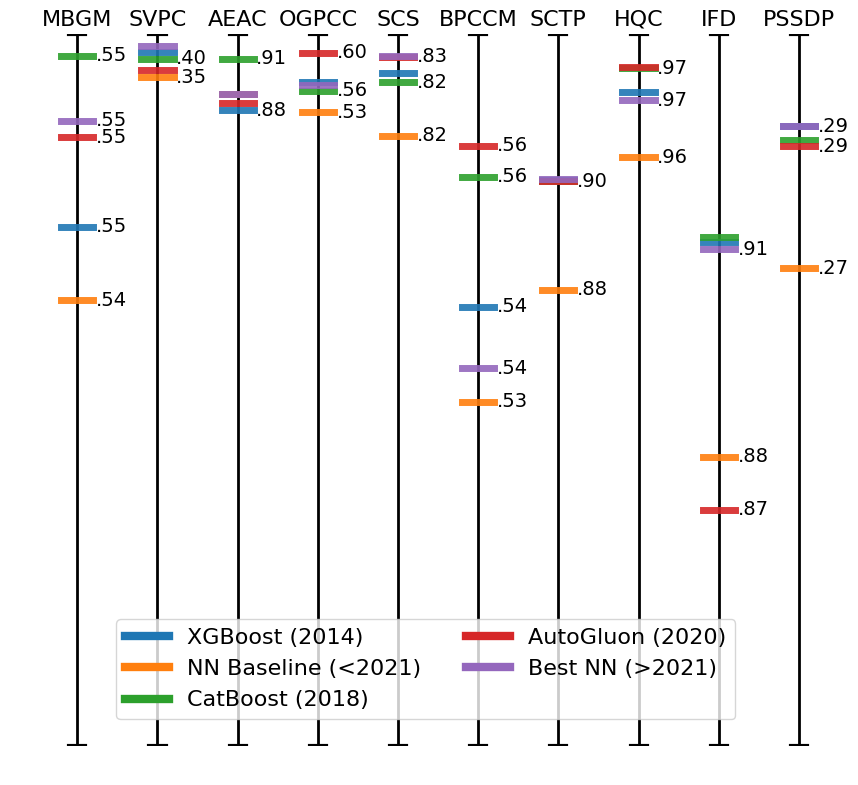

In [17]:
# Create a figure with one subplot per dataset
fig, axs = plt.subplots(1, len(dataset_names), figsize=(len(dataset_names), 8))  # Adjust width as needed

y_labels = ["XGBoost (2014)", "NN Baseline (<2021)", "CatBoost (2018)", "AutoGluon (2020)", "Best NN (>2021)"]#,"Top Expert Solution"]
colors = {i: j for i, j in zip(y_labels, ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'])}


# Function to plot the data
def plot_data(ax, dataset_name):
    y_markers = [
        df_min_extensive.loc[dataset_name, "XGBoost"], 
        df_min_extensive.loc[dataset_name, "ResNet"], 
        df_min_extensive.loc[dataset_name, "CatBoost"],
        df_min_auto.loc[dataset_name, "AutoGluon"],
        df_min_extensive.loc[dataset_name, ["ResNet", "MLP-PLR", "FTTransformer", "GRANDE"]].max(),
        # best_per_dataset.loc[dataset_name]
    ]
    y_values = y_markers

    # Updated colors for publication
    ax.axvline(x=0, color='black', linestyle='-', linewidth=2)
    ax.axhline(y=lb_dataset[dataset_name]["PrivateScore"].min(), color='black', linestyle='-', linewidth=3, xmin=0.35, xmax=0.65)
    ax.axhline(y=lb_dataset[dataset_name]["PrivateScore"].max(), color='black', linestyle='-', linewidth=3, xmin=0.35, xmax=0.65)

    # Plot horizontal lines
    for y, label in zip(y_markers, y_labels):
        if dataset_name=="SVPC" and label=="AutoGluon":
            ax.axhline(y=y, color=colors[label], linestyle='-', linewidth=6, xmin=0.2, xmax=0.5, alpha=0.9)  # Set alpha for transparency
        elif dataset_name=="SVPC" and label=="NN Baseline":
            ax.axhline(y=y, color=colors[label], linestyle='-', linewidth=6, xmin=0.5, xmax=0.8, alpha=0.9)  # Set alpha for transparency
        elif dataset_name=="AEAC" and label=="NN Baseline":
            ax.axhline(y=y, color=colors[label], linestyle='-', linewidth=6, xmin=0.2, xmax=0.5, alpha=0.9)  # Set alpha for transparency
        elif dataset_name=="AEAC" and label=="Best NN":
            ax.axhline(y=y, color=colors[label], linestyle='-', linewidth=6, xmin=0.5, xmax=0.8, alpha=0.9)  # Set alpha for transparency
        elif dataset_name=="HQC" and label=="AutoGluon":
            ax.axhline(y=y, color=colors[label], linestyle='-', linewidth=6, xmin=0.2, xmax=0.5, alpha=0.9)  # Set alpha for transparency
        elif dataset_name=="HQC" and label=="CatBoost":
            ax.axhline(y=y, color=colors[label], linestyle='-', linewidth=6, xmin=0.5, xmax=0.8, alpha=0.9)  # Set alpha for transparency
        elif dataset_name=="PSSDP" and label=="Best NN":
            ax.axhline(y=y, color=colors[label], linestyle='-', linewidth=6, xmin=0.2, xmax=0.5, alpha=0.9)  # Set alpha for transparency
        elif dataset_name=="PSSDP" and label=="XGBoost":
            ax.axhline(y=y, color=colors[label], linestyle='-', linewidth=6, xmin=0.5, xmax=0.8, alpha=0.9)  # Set alpha for transparency
        else:
            ax.axhline(y=y, color=colors[label], linestyle='-', linewidth=5, xmin=0.2, xmax=0.8, alpha=0.9)  # Set alpha for transparency

    # Sort markers by their y-values
    sorted_markers = sorted(zip(y_markers, y_labels), key=lambda x: x[0])
    
    # Plot text for the highest value in case of overlap
    last_y = -float('inf')
    for y, label in sorted_markers:
        if y - last_y >= lb_dataset[dataset_name]["PrivateScore"].std()/10:  # Adjust threshold as needed to prevent overlap
            if label == "Best Expert Solution":
                ax.text(0.35, y, f'{y:.2f}', rotation=0, verticalalignment='center', horizontalalignment='left', fontsize=14, color='black')
            elif round(y,2)==1:
                ax.text(0.35, y, f'{y:.1f}'.lstrip('0'), rotation=0, verticalalignment='center', horizontalalignment='left', fontsize=14, color='black')
            else:
                ax.text(0.35, y, f'{y:.2f}'.lstrip('0'), rotation=0, verticalalignment='center', horizontalalignment='left', fontsize=14, color='black')
            last_y = y
    
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.set_xlim(-0.5, 0.5)
    ax.set_ylim(lb_dataset[dataset_name]["PrivateScore"].min(), lb_dataset[dataset_name]["PrivateScore"].max())
    ax.tick_params(axis='y', direction='out', length=10, width=2, colors='black', grid_color='black', grid_alpha=0.5)
    ax.set_title(dataset_name, fontsize=16)

for num, dataset_name in enumerate(dataset_names):
    plot_data(axs[num], dataset_map[dataset_name])

# Add legend
handles = [plt.Line2D([0], [0], color=color, lw=6) for color in colors.values()]
labels = colors.keys()

# Move legend to the bottom closer to the plot
fig.legend(handles, labels, loc='lower center', ncol=len(colors)/2, fontsize=16, bbox_to_anchor=(0.5, 0.12))

# Add horizontal and vertical lines to separate the subplots
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)

# Adjust layout to make the plot narrower
plt.subplots_adjust(top=0.99, bottom=0.1, hspace=0.3, wspace=0.5)

plt.savefig('figures/progress_score.pdf', format='pdf', bbox_inches='tight', pad_inches=0)

# Display the combined plot
plt.show()

## Subsection 4.3: Most important modeling components per model

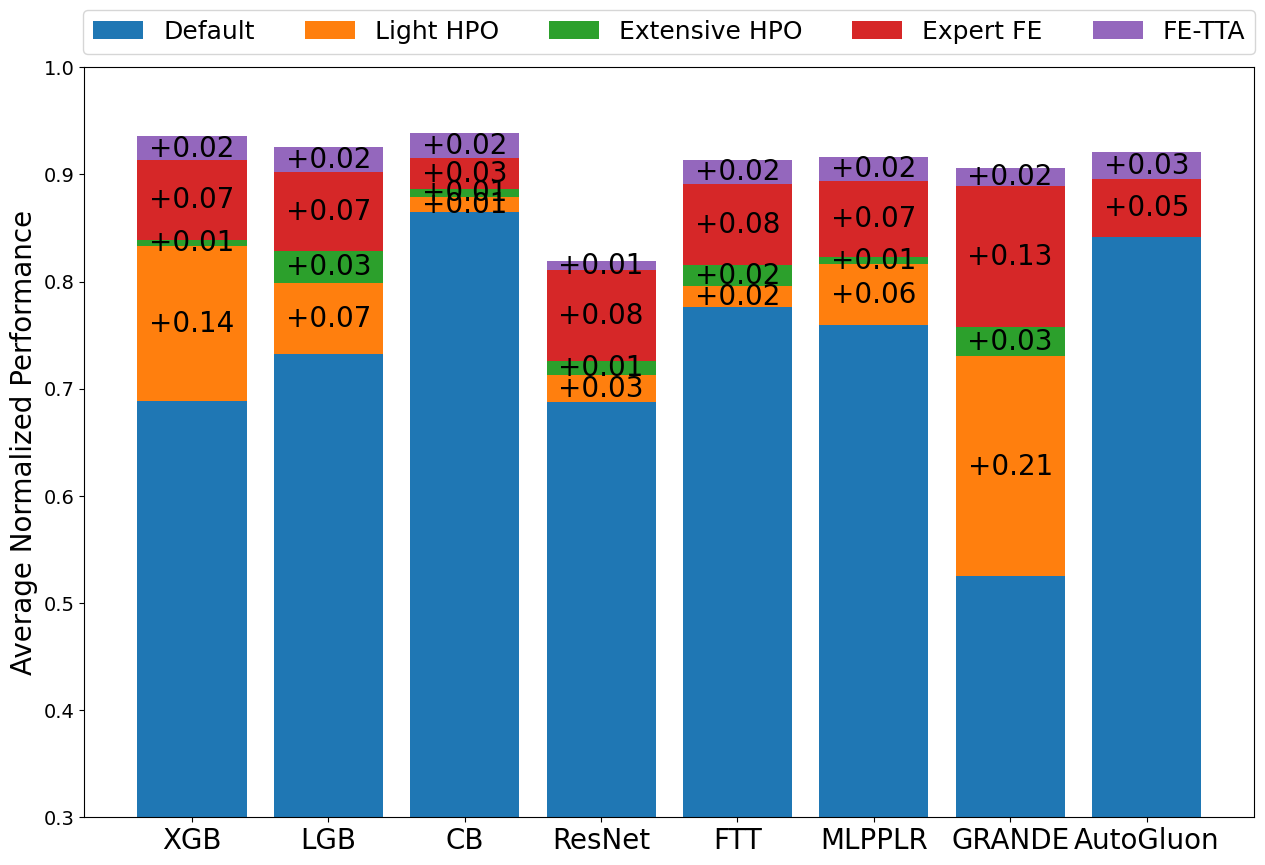

In [18]:
# Set up the figure and axes
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(13, 10))

# Set font sizes for LaTeX readability
plt.rc('font', size=20)
plt.rc('axes', titlesize=20)
plt.rc('axes', labelsize=20)
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)
plt.rc('legend', fontsize=20)

# Data preparation

def_ = pd.concat([df_min_def, df_min_auto], axis=1).fillna(0).apply(apply_adtm_data,axis=1)
light = pd.concat([df_min_light, df_min_auto], axis=1).fillna(0).apply(apply_adtm_data,axis=1)
ext = pd.concat([df_min_extensive, df_min_auto], axis=1).fillna(0).apply(apply_adtm_data,axis=1)
fe = pd.concat([df_fe_extensive, df_fe_auto], axis=1).fillna(0).apply(apply_adtm_data,axis=1)
tta = pd.concat([df_tta_extensive, df_tta_auto], axis=1).fillna(0).apply(apply_adtm_data,axis=1)


data = {
    'Default': def_.mean(axis=0),
    'Light HPO': light.mean(axis=0),
    'Extensive HPO': ext.mean(axis=0),
    'Expert FE': fe.mean(axis=0),
    'FE-TTA': tta.mean(axis=0),
}

labels = list(data.keys())
bottom = np.zeros(len(data[labels[0]]))

# Create the bar plots
for label in labels:
    axes.bar(np.arange(len(data[label])), data[label] - bottom, bottom=bottom, label=label)
    for i in range(len(data[label])):
        gain = data[label][i] - bottom[i]
        if round(gain,2)>0.009 and label!="Default":
            axes.text(i, bottom[i] + gain / 2, f'+{gain:.2f}', ha='center', va='center', color='black',fontsize=20)
    bottom += data[label] - bottom

axes.set_ylabel('Average Normalized Performance',fontsize=20)

axes.set_xticks(np.arange(len(data[labels[0]])))
axes.set_xticklabels([model_map[mod] for mod in list(df_min_def.columns) + ["AutoGluon"]],fontsize=20)

axes.set_ylim(0.3, 1.0)  # Adjust the y-axis limit to fit the data

# Create a single legend at the top of the figure
handles, labels = axes.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=5, bbox_to_anchor=(0.5, 1.02),fontsize=18)

# Adjust layout manually to prevent overlapping
plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.2, wspace=0.1, hspace=0.1)

# Save the plot as a PDF file
plt.savefig('figures/mean_model_gain_score.pdf', format='pdf', bbox_inches='tight', pad_inches=0)

plt.show()

### Subsection 4.4: Isolated look at test-time adaptation

In [19]:
min_all = pd.concat([df_min_extensive,df_min_auto],axis=1).loc[['AEAC', 'OGPCC', 'SCS', 'SCTP', 'IFD', 'PSSDP']]
fe_all = pd.concat([df_fe_extensive,df_fe_auto],axis=1).loc[['AEAC', 'OGPCC', 'SCS', 'SCTP', 'IFD', 'PSSDP']]
tta_all = pd.concat([df_tta_extensive,df_tta_auto],axis=1).loc[['AEAC', 'OGPCC', 'SCS', 'SCTP', 'IFD', 'PSSDP']]

best_single = pd.DataFrame([min_all.drop("AutoGluon",axis=1).max(axis=1),fe_all.drop("AutoGluon",axis=1).max(axis=1),tta_all.drop("AutoGluon",axis=1).max(axis=1)]).transpose().round(3)
best_single.columns = ["Standardized", "Expert FE", "FE-TTA"]

auto = pd.DataFrame([min_all["AutoGluon"],fe_all["AutoGluon"],tta_all["AutoGluon"]]).transpose().round(3)
auto.columns = ["Standardized", "Expert FE", "FE-TTA"]

all = pd.concat({"Best single model": best_single, "AutoGluon": auto},axis=1)
all


Best single model                     AutoGluon                 
           Standardized Expert FE FE-TTA Standardized Expert FE FE-TTA
AEAC              0.909     0.904  0.917        0.882     0.909  0.919
OGPCC             0.569     0.562  0.575        0.598     0.587  0.597
SCS               0.827     0.827  0.827        0.827     0.828  0.829
SCTP              0.898     0.900  0.920        0.898     0.898  0.919
IFD               0.919     0.932  0.935        0.871     0.902  0.908
PSSDP             0.288     0.291  0.291        0.286     0.289  0.289

In [20]:
print(all.astype(str).to_latex())

\begin{tabular}{lllllll}
\toprule
 & \multicolumn{3}{r}{Best single model} & \multicolumn{3}{r}{AutoGluon} \\
 & Standardized & Expert FE & FE-TTA & Standardized & Expert FE & FE-TTA \\
\midrule
AEAC & 0.909 & 0.904 & 0.917 & 0.882 & 0.909 & 0.919 \\
OGPCC & 0.569 & 0.562 & 0.575 & 0.598 & 0.587 & 0.597 \\
SCS & 0.827 & 0.827 & 0.827 & 0.827 & 0.828 & 0.829 \\
SCTP & 0.898 & 0.9 & 0.92 & 0.898 & 0.898 & 0.919 \\
IFD & 0.919 & 0.932 & 0.935 & 0.871 & 0.902 & 0.908 \\
PSSDP & 0.288 & 0.291 & 0.291 & 0.286 & 0.289 & 0.289 \\
\bottomrule
\end{tabular}



# Appendix C: Detailed Results

In [21]:
lb = pd.read_csv(f"datasets/{dataset_name}/leaderboard.csv")
std = lb["PrivateScore"].loc[lb["PrivateScore"]>lb["PrivateScore"].quantile(0.99)].std()
std

0.0009671655372637069

In [22]:
df_min_all = pd.concat({"Default": df_min_def, "Light": df_min_light,"Extensive": df_min_extensive})
df_min_all_latex = df_min_all.copy().round(4).astype(str)
df_min_all_latex[(df_min_all.transpose()>df_min_all.max(axis=1)-std).transpose()] = "\\textbf{" + df_min_all_latex[(df_min_all.transpose()>df_min_all.max(axis=1)-std).transpose()] + "}"
print(df_min_all_latex.to_latex())

\begin{tabular}{lllllllll}
\toprule
 &  & XGBoost & LightGBM & CatBoost & ResNet & FTTransformer & MLP-PLR & GRANDE \\
\midrule
\multirow[t]{10}{*}{Default} & MBGM & 0.5276 & 0.5363 & \textbf{0.554} & 0.5366 & 0.5398 & 0.5483 & 0.52 \\
 & SVPC & 0.3666 & \textbf{0.419} & 0.3945 & 0.3348 & 0.3433 & 0.4041 & 0.3249 \\
 & AEAC & 0.8754 & 0.881 & \textbf{0.9005} & 0.8653 & 0.8738 & 0.8707 & 0.8302 \\
 & OGPCC & \textbf{0.5525} & 0.5501 & 0.5482 & 0.5293 & 0.5356 & 0.5443 & 0.5259 \\
 & SCS & 0.8239 & 0.8232 & 0.824 & 0.8205 & \textbf{0.825} & 0.8223 & 0.8206 \\
 & BPCCM & 0.525 & 0.5295 & \textbf{0.5539} & 0.5262 & 0.5295 & 0.5325 & 0.4148 \\
 & SCTP & 0.8892 & 0.893 & \textbf{0.8965} & 0.8666 & 0.894 & 0.8863 & 0.8942 \\
 & HQC & 0.96 & 0.9612 & \textbf{0.9679} & 0.9636 & 0.9664 & 0.9651 & 0.966 \\
 & IFD & 0.8989 & 0.9006 & \textbf{0.9121} & 0.8799 & 0.9065 & 0.8965 & 0.859 \\
 & PSSDP & 0.2703 & 0.2724 & \textbf{0.2843} & 0.274 & 0.283 & 0.2655 & 0.2766 \\
\cline{1-9}
\multirow[t]{10}{*

In [23]:
df_fe_all = pd.concat({"Default": df_fe_def, "Light": df_fe_light,"Extensive": df_fe_extensive})
df_fe_all_latex = df_fe_all.copy().round(4).astype(str)
df_fe_all_latex[(df_fe_all.transpose()>df_fe_all.max(axis=1)-std).transpose()] = "\\textbf{" + df_fe_all_latex[(df_fe_all.transpose()>df_fe_all.max(axis=1)-std).transpose()] + "}"
print(df_fe_all_latex.to_latex())

\begin{tabular}{lllllllll}
\toprule
 &  & XGBoost & LightGBM & CatBoost & ResNet & FTTransformer & MLP-PLR & GRANDE \\
\midrule
\multirow[t]{10}{*}{Default} & MBGM & 0.5499 & 0.5473 & \textbf{0.5546} & 0.5485 & 0.5488 & 0.5524 & 0.5483 \\
 & SVPC & \textbf{0.4683} & 0.4643 & 0.4646 & 0.4369 & 0.457 & 0.4665 & 0.4409 \\
 & AEAC & 0.8947 & 0.8992 & \textbf{0.9039} & 0.8881 & 0.901 & 0.8168 & 0.816 \\
 & OGPCC & \textbf{0.5504} & 0.5473 & 0.5484 & 0.528 & 0.5327 & 0.5359 & 0.5227 \\
 & SCS & 0.8249 & \textbf{0.8261} & 0.8254 & 0.8203 & \textbf{0.8267} & 0.8239 & 0.8216 \\
 & BPCCM & 0.5672 & \textbf{0.5676} & 0.5668 & 0.5627 & 0.5667 & \textbf{0.5681} & 0.5651 \\
 & SCTP & 0.885 & 0.8939 & \textbf{0.8962} & 0.8643 & 0.8942 & 0.8906 & 0.8952 \\
 & HQC & 0.9618 & 0.9631 & \textbf{0.968} & 0.9661 & \textbf{0.968} & 0.9642 & 0.9628 \\
 & IFD & \textbf{0.9275} & 0.9255 & 0.9255 & 0.8759 & 0.9233 & 0.9173 & 0.9097 \\
 & PSSDP & 0.2841 & 0.283 & 0.2895 & 0.2848 & \textbf{0.2911} & 0.2779 & 0.278

In [24]:
df_tta_all = pd.concat({"Default": df_tta_def.loc[['AEAC', 'OGPCC', 'SCS', 'SCTP', 'IFD','PSSDP']], 
                        "Light": df_tta_light.loc[['AEAC', 'OGPCC', 'SCS', 'SCTP', 'IFD','PSSDP']],
                        "Extensive": df_tta_extensive.loc[['AEAC', 'OGPCC', 'SCS', 'SCTP', 'IFD','PSSDP']]})
df_tta_all_latex = df_tta_all.copy().round(4).astype(str)
df_tta_all_latex[(df_tta_all.transpose()>df_tta_all.max(axis=1)-std).transpose()] = "\\textbf{" + df_tta_all_latex[(df_tta_all.transpose()>df_tta_all.max(axis=1)-std).transpose()] + "}"
print(df_tta_all_latex.to_latex())

\begin{tabular}{lllllllll}
\toprule
 &  & XGBoost & LightGBM & CatBoost & ResNet & FTTransformer & MLP-PLR & GRANDE \\
\midrule
\multirow[t]{6}{*}{Default} & AEAC & 0.9055 & 0.9066 & \textbf{0.9144} & 0.893 & 0.8967 & 0.8472 & 0.8388 \\
 & OGPCC & \textbf{0.5601} & 0.5578 & 0.5567 & 0.5312 & 0.5309 & 0.5452 & 0.5326 \\
 & SCS & 0.8247 & 0.8251 & 0.8255 & 0.8214 & \textbf{0.8268} & 0.8253 & 0.823 \\
 & SCTP & 0.9143 & 0.9154 & \textbf{0.9168} & 0.8797 & 0.9135 & 0.915 & \textbf{0.917} \\
 & IFD & \textbf{0.9307} & \textbf{0.9301} & 0.9284 & 0.8755 & 0.9254 & 0.9129 & 0.9132 \\
 & PSSDP & 0.284 & 0.2834 & 0.2895 & 0.2865 & \textbf{0.2906} & 0.2741 & 0.2786 \\
\cline{1-9}
\multirow[t]{6}{*}{Light} & AEAC & 0.9069 & 0.9113 & \textbf{0.9171} & 0.9034 & 0.9052 & 0.898 & 0.8655 \\
 & OGPCC & 0.568 & \textbf{0.5729} & 0.5589 & 0.536 & 0.5412 & 0.5571 & 0.4878 \\
 & SCS & \textbf{0.8271} & \textbf{0.8263} & \textbf{0.8262} & 0.8227 & \textbf{0.8269} & 0.8251 & 0.8242 \\
 & SCTP & 0.9173 & 0.917

In [25]:
df_auto_all = pd.concat({"Default": df_min_auto["AutoGluon"], "Expert FE": df_fe_auto["AutoGluon"],"FE-TTA": df_tta_auto["AutoGluon"]},axis=1)
df_auto_all_latex = df_auto_all.copy().round(4).astype(str)
df_auto_all_latex[(df_auto_all.transpose()>df_auto_all.max(axis=1)-std).transpose()] = "\\textbf{" + df_auto_all_latex[(df_auto_all.transpose()>df_auto_all.max(axis=1)-std).transpose()] + "}"

print(df_auto_all_latex.transpose().to_latex())

\begin{tabular}{lllllllllll}
\toprule
 & MBGM & SVPC & AEAC & OGPCC & SCS & BPCCM & SCTP & HQC & IFD & PSSDP \\
\midrule
Default & 0.5505 & 0.366 & 0.8816 & \textbf{0.5979} & 0.827 & 0.565 & 0.8978 & \textbf{0.9689} & 0.8711 & 0.2858 \\
Expert FE & \textbf{0.5524} & \textbf{0.4547} & 0.9087 & 0.5873 & \textbf{0.8285} & \textbf{0.5678} & 0.8984 & \textbf{0.9692} & 0.9024 & \textbf{0.2889} \\
FE-TTA & \textbf{0.5524} & \textbf{0.4547} & \textbf{0.9194} & \textbf{0.5971} & \textbf{0.8292} & \textbf{0.5678} & \textbf{0.9194} & \textbf{0.9692} & \textbf{0.908} & \textbf{0.2894} \\
\bottomrule
\end{tabular}

